In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [3]:
def load_sudoku(filename):
    with open(f"sudoku_boards/{filename}", "r") as file:
        return [[int(x) for x in (row[:-1] if row[-1]=='\n' else row)] for row in file.readlines()]

In [46]:
def show_sudoku(board, filled=True, filename=""):
    m = 360
    d = m // 9
    img = Image.new(mode="RGB", size=(m, m), color=(176, 165, 155))
    draw = ImageDraw.Draw(img)
    for i in range(9):
        draw.line([(i*d, 0), (i*d, m)], width=1, fill=(0, 0, 0))
        draw.line([(0, i*d), (m, i*d)], width=1, fill=(0, 0, 0))

    for i in range(1, 3):
        draw.line([(3*i*d, 0), (3*i*d, m)], width=3, fill=(0, 0, 0))
        draw.line([(0, 3*i*d), (m, 3*i*d)], width=3, fill=(0, 0, 0))

    font = ImageFont.truetype("arial.ttf", 20)
    for i in range(9):
        for j in range(9):
            fill_color = 'blue' if fixed[i][j] else 'red'
            if fixed[i][j] or filled:
                draw.text((j*d + d/2.5, i*d + d/3.5), text=str(board[i][j]), font=font, fill=fill_color)
    display(img)
    if filename:
        img.save(f"solved_sudoku_boards/{filename}.png")

def plot_energy(energy):
    plt.plot([ind for ind in range(len(energy))], energy)
    plt.title("Energy plot")
    plt.show()


def plot_temperature(temperature):
    plt.plot([ind for ind in range(len(temperature))], temperature)
    plt.title("Temperature plot")
    plt.show()

#### Algorytm generowania sąsiadów

W sudoku liczby nie moga powtarzać sie w żadnej kolumnie, rzędzie ani kwadracie 3x3. Najtrudniej jest na biężaco sprawdzać warunek kwadratów, a wiadomo, że w każdym kwadracie musi znajdować się permutacja cyfr od 1 do 9, więc na początku uzpełniam liczby tak, żeby nie powtarzały się w obrębie jednego kwadratu. Generowanie sąsiadów polega na wylosowaniu dowolnego kwadratu z spośród 9, a następnie zamienie wewnątrz niego dwóch dowolnych liczb.

Klasa square opisuje wolne miejsca wewnątrz każdego kwadratu.



In [47]:
class Square:
    def __init__(self, x, y, board):
        self.x = x
        self.y = y
        self.positions = []
        self.fill_positions(board)
        self.length = len(self.positions)

    def fill_positions(self, board):
        number = [False for _ in range(9)]
        empty_spots = []
        for i in range(self.x, self.x + 3):
            for j in range(self.y, self.y + 3):
                if fixed[i][j]:
                    number[board[i][j] - 1] = True
                else:
                    empty_spots.append((i, j))

        for i in range(9):
            if not number[i]:
                pos = empty_spots.pop()
                self.positions.append(pos)
                board[pos[0]][pos[1]] = i + 1

def initial_fill(board):
    sqr = [_ for _ in range(9)]
    square_id = 0
    t = [0, 3, 6]
    for x in t:
        for y in t:
            sqr[square_id] = Square(x, y, board)
            square_id += 1
    return sqr


Funkcja kosztu jest taka jak w poleceniu. Ponadto wiadomo, że energii nie trzeba uwzględniać powtórzeń z kwadratów 3x3. Tablice rows_count i columns_count trzymają informację o tym ile razy w danym rzędzie/kolumnie powtarza się dana liczba.

Funkcja calculate_initial_energy oblicza początkowy stan energii, a funkcja calculate_cur_energy jest używana przy obliczaniu zmiany energii przy przejściu z jednego stanu do drugiego

In [48]:
def count_cols_and_rows(board, rows_count, columns_count):
    for i in range(9):
        for j in range(9):
            rows_count[i][board[i][j] - 1] += 1
            columns_count[j][board[i][j] - 1] += 1

def calculate_initial_energy(rows_count, columns_count):
    energy = 0
    for i in range(9):
        for j in range(9):
            energy += rows_count[i][j] - 1 if rows_count[i][j] > 0 else 0
            energy += columns_count[i][j] - 1 if columns_count[i][j] > 0 else 0
    return energy

def calculate_cur_energy(r1, r2, c1, c2, num1, num2, rows_count, columns_count):
    energy = 0
    for row in [r1, r2]:
        for num in [num1, num2]:
            energy += rows_count[row][num - 1] - 1 if rows_count[row][num - 1] > 0 else 0

    for col in [c1, c2]:
        for num in [num1, num2]:
            energy += columns_count[col][num - 1] - 1 if columns_count[col][num - 1] > 0 else 0
    return energy

Funkcje generujące sąsiadów i zamieniające dwa pola miejscami.

In [49]:
def swap_nums(board, pos1, pos2, rows_count, columns_count):
    num1 = board[pos1[0]][pos1[1]]
    num2 = board[pos2[0]][pos2[1]]

    board[pos1[0]][pos1[1]], board[pos2[0]][pos2[1]] = board[pos2[0]][pos2[1]], board[pos1[0]][pos1[1]]

    rows_count[pos1[0]][num1 - 1] -= 1
    columns_count[pos1[1]][num1 - 1] -= 1
    rows_count[pos2[0]][num2 - 1] -= 1
    columns_count[pos2[1]][num2 - 1] -= 1

    rows_count[pos2[0]][num1 - 1] += 1
    columns_count[pos2[1]][num1 - 1] += 1
    rows_count[pos1[0]][num2 - 1] += 1
    columns_count[pos1[1]][num2 - 1] += 1


def neighbor(board, squares, rows_count, columns_count):
    square_id = np.random.randint(0, 9)
    square = squares[square_id]
    m = square.length
    a = np.random.randint(0, m - 1)
    b = np.random.randint(a + 1, m)
    pos1 = square.positions[a]
    pos2 = square.positions[b]

    num1 = board[pos1[0]][pos1[1]]
    num2 = board[pos2[0]][pos2[1]]

    before = calculate_cur_energy(pos1[0], pos2[0], pos1[1], pos2[1], num1, num2, rows_count, columns_count)
    swap_nums(board, pos1, pos2, rows_count, columns_count)
    after = calculate_cur_energy(pos1[0], pos2[0], pos1[1], pos2[1], num2, num1, rows_count, columns_count)
    return (pos1, pos2), after - before

Sprawdza czy sudoku jest poprawnie rozwiązane

In [50]:
def check_correctness(board):
    row_check = [[False for _ in range(9)] for _ in range(9)]
    col_check = [[False for _ in range(9)] for _ in range(9)]
    square_check = [[False for _ in range(9)] for _ in range(9)]
    for i in range(9):
        for j in range(9):
            if row_check[i][board[i][j] - 1]:
                return False
            row_check[i][board[i][j] - 1] = True
            if col_check[j][board[i][j] - 1]:
                return False
            col_check[j][board[i][j] - 1] = True

            square_id = (i // 3)*3 + (j // 3)
            if square_check[square_id][board[i][j] - 1]:
                return False
            square_check[square_id][board[i][j] - 1] = True

    return True

#### Algorytm wyżarzania
Analogicznie jak w zadaniu pierwszym i drugim jako funkcji prawdopodobieństwa używam $exp\frac{\Delta}{T}$, gdzie $\Delta$ to zmiana energii, a $T$ to temperatura w danej iteracji. Dla danego poziomu temperatury wykonuje więcej niż jedną iterację szukania kolejnych stanów. Ponadto w odróżnieniu do poprzednich programów pojawiła się jeszcze jedna pętla zewnętrzna. Odpowiada ona za "reheating". W sudoku poszukiwane jest tylko rozwiązanie o poziomie energii 0 i stan o niskim poziomie energii może znajdować się bardzo daleko od optymalnego rozwiązanie. Dlatego, gdy algorytm osiągnie taki niski ale niezerowy stan energytyczny jest bardzo trudne, aby w przy niskiej temperaturze doszedł do rozwiązania optymalnego. W takiej sytuacji poszukiwanie jest uruchamiane od nowa, ale przy niższej temperaturze startowej. Temperatura startowa kolejnych takich procesów jest odwrotnie proporcjonalna do numeru iteracji, a w obrębie jednego procesu temperatura spada wykładniczo.

In [51]:
def f(delta, T):
    return np.exp(-delta/T)

In [61]:
def annealing(board, T0 = 100, alpha = 0.99, steps=1000, no_of_iter=10, max_iter = 10, filename=""):
    show_sudoku(board, filled=False, filename=f"unsolved_{filename}")
    squares = initial_fill(board)
    columns_count = [[0 for _ in range(9)] for _ in range(9)]
    rows_count = [[0 for _ in range(9)] for _ in range(9)]
    count_cols_and_rows(board, rows_count, columns_count)

    cur_energy = calculate_initial_energy(rows_count, columns_count)
    energy_states = [cur_energy]


    T = T0
    temperature = [T]
    stop = False
    iter_so_far = 1
    while not stop and iter_so_far < max_iter:
        for i in range(steps):
            for _ in range(no_of_iter):
                change, delta = neighbor(board, squares, rows_count, columns_count)
                if delta < 0:
                    cur_energy += delta
                else:
                    probability = f(delta, T)
                    if probability > np.random.uniform(0, 1):
                        cur_energy += delta
                    else:
                        swap_nums(board, change[0], change[1], rows_count, columns_count)
                energy_states.append(cur_energy)
                if cur_energy == 0:
                    stop = True
                    break
            T *= alpha
            temperature.append(T)
            if stop:
                break
        iter_so_far += 1
        T = T0 / iter_so_far


    show_sudoku(board, filename=f"solved_{filename}")

    print(f"Number of reheating {iter_so_far - 1}")
    plot_energy(energy_states)
    plot_temperature(temperature)

### Wyniki dla róznych sudoku

Różne plansze pobrałem ze strony https://sudoku.com/. Pliki tekstowe z tymi planszami znajdują się w folderze sudoku_boards,
Poziomy trudności to easy, medium, hard, expert oraz diabolical. Odpowiadają one kolejnym poziomą trudności ze wspomnianej strony. Dołożyłem także plansze "empty" - pustą i "nondeterministic", czyli częściowo uzupełnioną ale nieposiadającą jednoznacznego rozwiązania.

Funkcja licząca czas rozwiązania. ( wlicza także czas rysowania sudoku i wykresów )

In [53]:
from time import perf_counter
def time(func, *args, **kwargs):
    t = perf_counter()
    func(*args, **kwargs)
    print(f"Czas rozwiązania: {np.round(perf_counter() - t, 2)}")

In [62]:
sudoku = load_sudoku("sudoku_easy")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

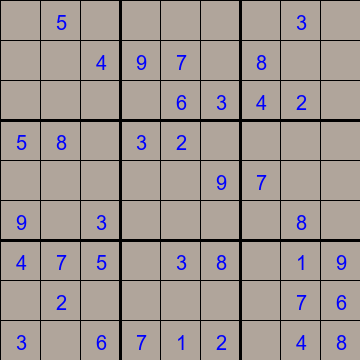

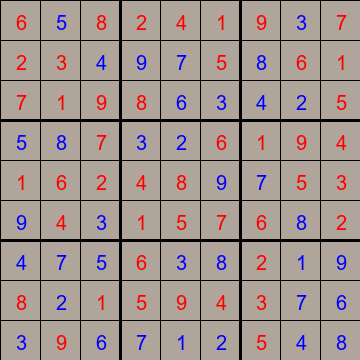

Number of reheating 2


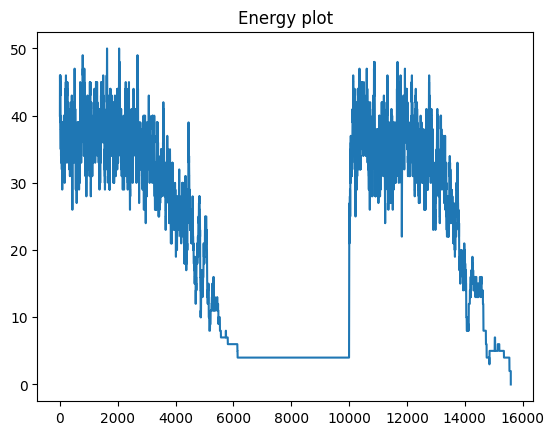

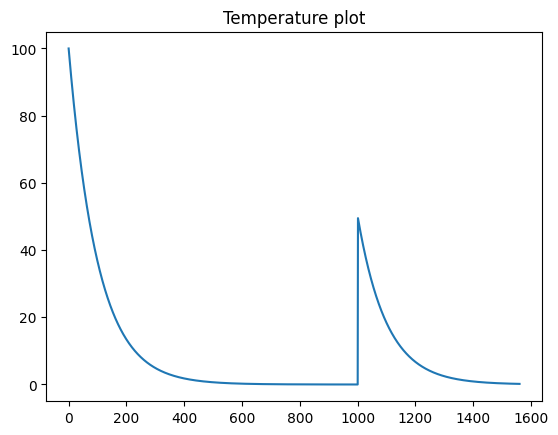

Czas rozwiązania: 1.23
Czy poprawne: True


In [63]:
time(annealing, sudoku, max_iter=1000, filename="easy")
print(f"Czy poprawne: {check_correctness(sudoku)}")

In [64]:
sudoku = load_sudoku("sudoku_medium")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

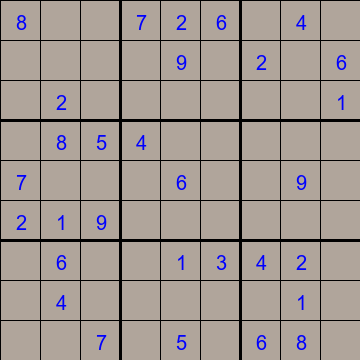

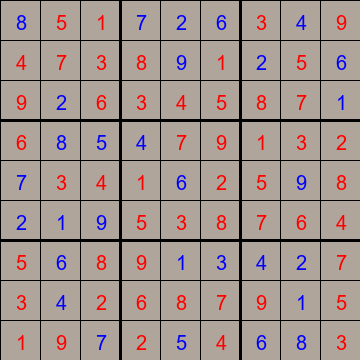

Number of reheating 8


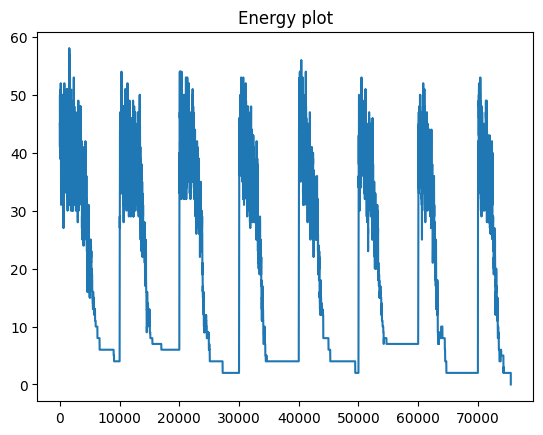

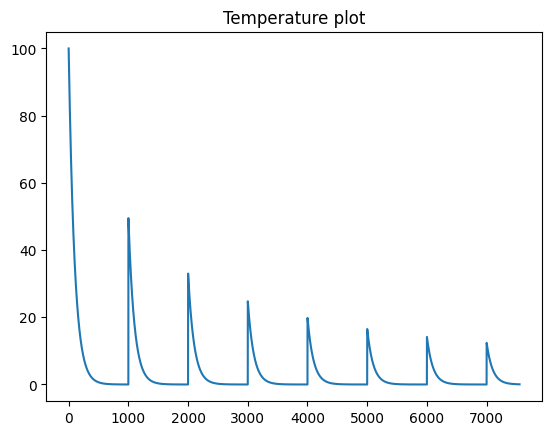

Czas rozwiązania: 2.41
Czy poprawne: True


In [65]:
time(annealing, sudoku, max_iter=1000, filename="medium")
print(f"Czy poprawne: {check_correctness(sudoku)}")

Dla sudoku z poziomu easy i medium nie było żadnego problemu. Praktycznie za każdym razem rozwiązywały się natychmiastowo

In [66]:
sudoku = load_sudoku("sudoku_hard")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

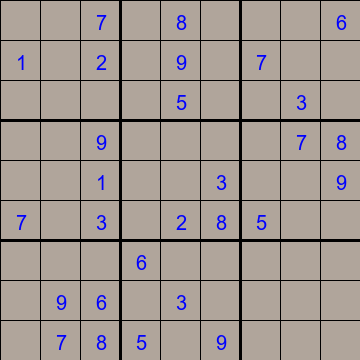

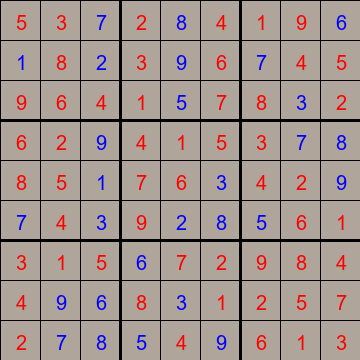

Number of reheating 32


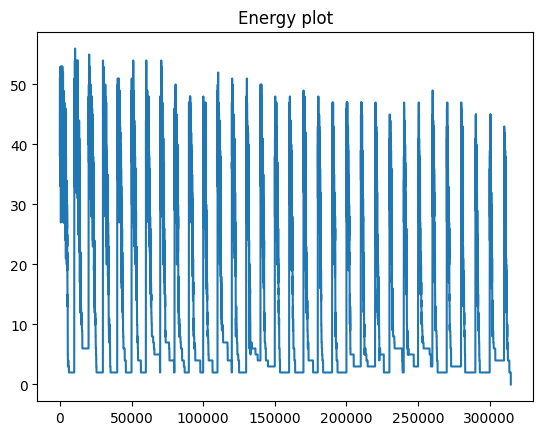

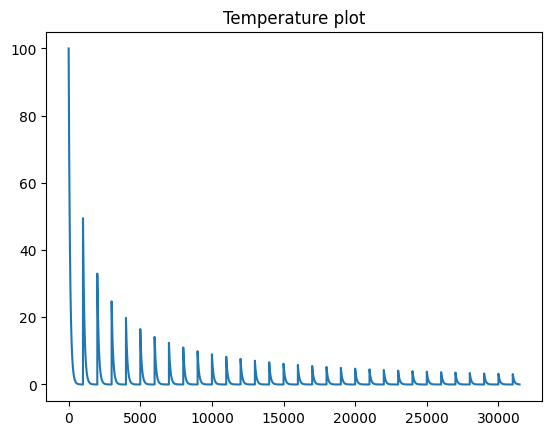

Czas rozwiązania: 7.56
Czy poprawne: True


In [67]:
time(annealing, sudoku, max_iter=1000, filename="hard")
print(f"Czy poprawne: {check_correctness(sudoku)}")

Rozwiązanie hard potrzebowało znacznie więcej iteracji.

In [68]:
sudoku = load_sudoku("sudoku_expert")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

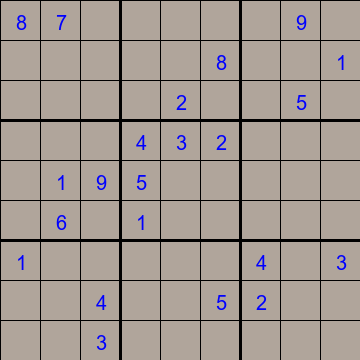

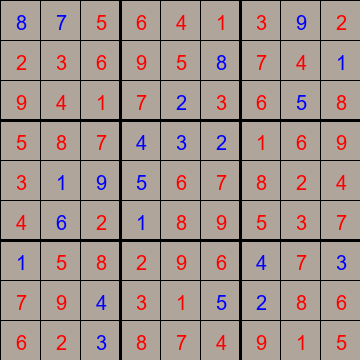

Number of reheating 131


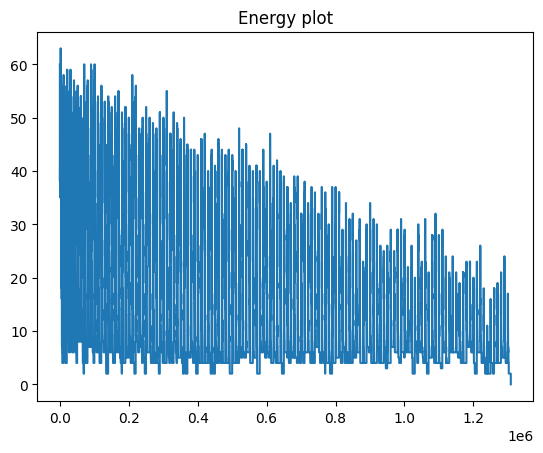

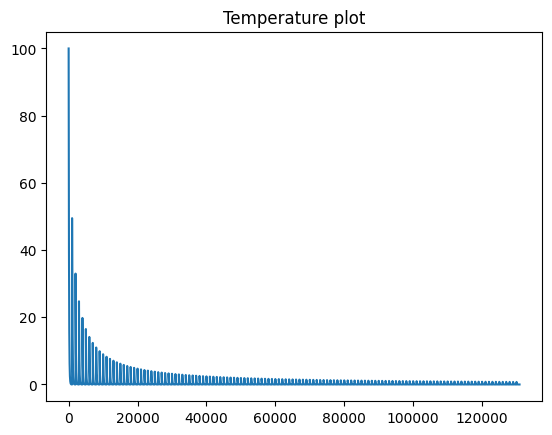

Czas rozwiązania: 33.75
Czy poprawne: True


In [69]:
time(annealing, sudoku, max_iter=1000, filename="expert")
print(f"Czy poprawne: {check_correctness(sudoku)}")

Wynik dla sudoku_extreme był już znacznie bardziej losowy. Czasami wystarczające było niewieli ponad dwadzieścia iteracji albo 130 tak jak na rysunku

In [73]:
sudoku = load_sudoku("sudoku_evil")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

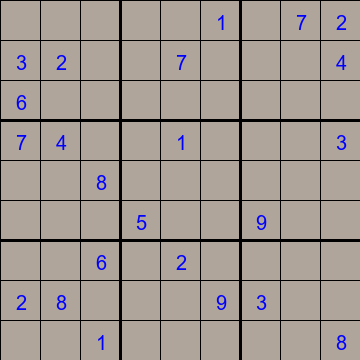

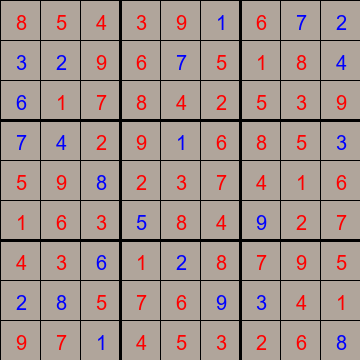

Number of reheating 139


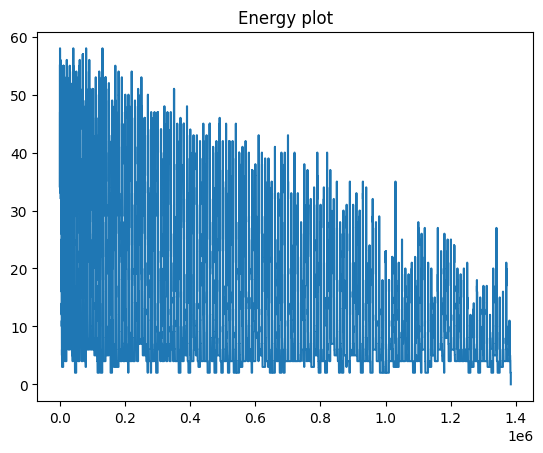

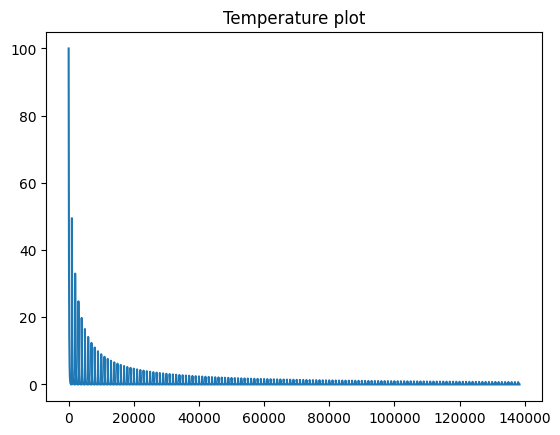

Czas rozwiązania: 30.49
Czy poprawne: True


In [74]:
time(annealing, sudoku, max_iter=1000, filename="evil")
print(f"Czy poprawne: {check_correctness(sudoku)}")

Evil okazał się być najtrudniejszy. Odpowiedź znajdywano w średnio 150 iteracjach.

Na koniec zostały bonusowe plansze "empty" i "nondeterministic ale obie rozwiązywały się bardzo szybko

In [103]:
sudoku = load_sudoku("sudoku_empty")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

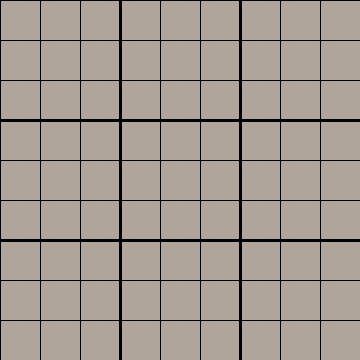

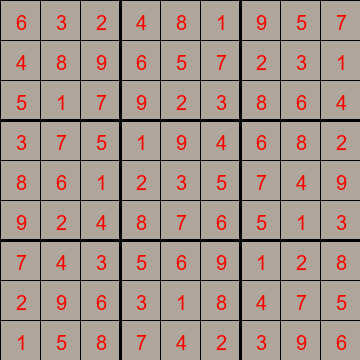

Number of reheating 1


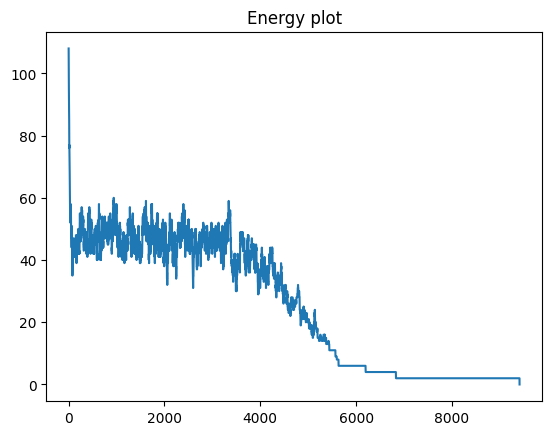

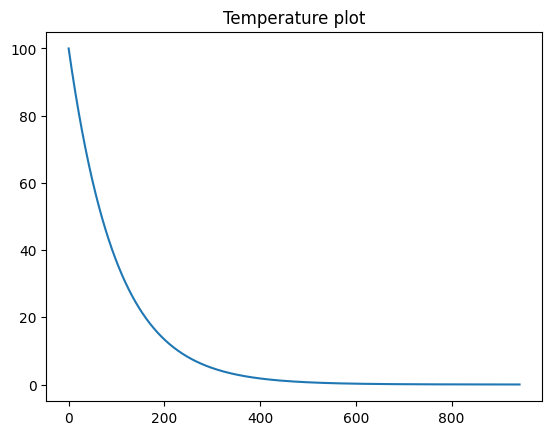

Czas rozwiązania: 0.61
Czy poprawne: True


In [104]:
time(annealing, sudoku, max_iter=100, filename="empty")
print(f"Czy poprawne: {check_correctness(sudoku)}")

In [105]:
sudoku = load_sudoku("sudoku_nondeterministic")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

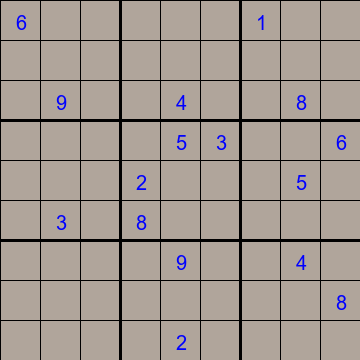

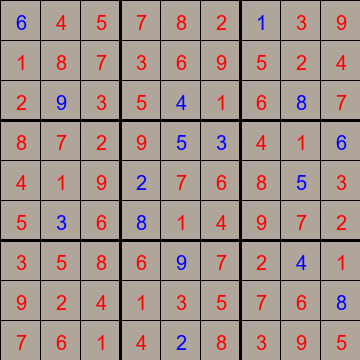

Number of reheating 5


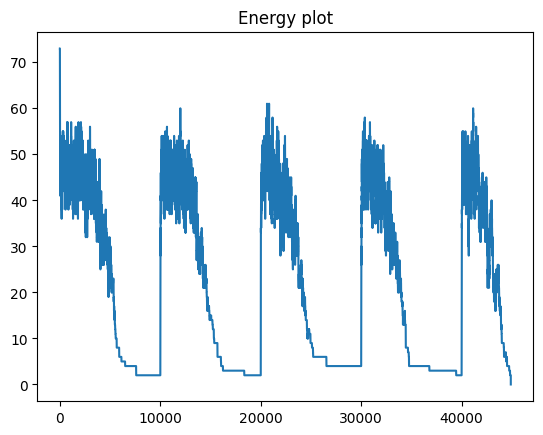

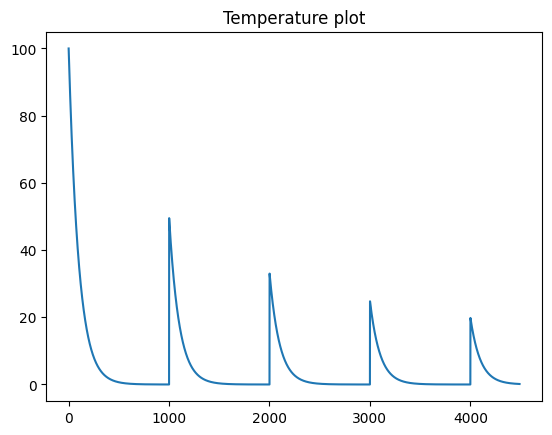

Czas rozwiązania: 1.83
Czy poprawne: True


In [106]:
time(annealing, sudoku, max_iter=100, filename="nondeterministic")
print(f"Czy poprawne: {check_correctness(sudoku)}")